<a href="https://colab.research.google.com/github/veotani/ml-univsersity-course-ms-3sem/blob/master/Recommender%20System%20Subset%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

from zipfile import ZipFile
from os import listdir
from scipy.sparse import csr_matrix, find
from scipy.sparse.linalg import svds
from matplotlib import pyplot
from tqdm import tqdm_notebook
from sklearn.neighbors import NearestNeighbors

# Считывание и обработка входных данных

In [0]:
# Считываем данные
INPUT_FILES_PATH = 'drive/My Drive/study-science/Интеллектуальный анализ данных/'

users =   [] # user ids   translated into row indeces (which are 1 less than id)
movies =  [] # movies ids translated into col indeces (which are 1 less than id)
ratings = [] # rating[k] = (rating that users[k] user gave to movies[k] movie)

new_user_ids = dict()
users_count = 0

for file_part in range(1, 5): # the training data is splited into 4 parts
  filename = INPUT_FILES_PATH + f'combined_data_{file_part}.txt'
  with open(filename) as f:
    for line in f:
      if ':' in line:
        current_movie = int(line.split(':')[0]) - 1
        continue
      user, rating, _ = line.split(',')
      if user in new_user_ids:
        current_user = new_user_ids[user]
      else:
        new_user_ids[user] = users_count
        current_user = users_count
        users_count += 1
      current_rating = int(rating)
      users.append(current_user)
      movies.append(current_movie)
      ratings.append(current_rating)

# Возьмём 10% датасета
max_user_id = ((max(users) + 1)) // 10
max_movie_id = ((max(movies)) + 1) // 10

users_subset = []
movies_subset = []
ratings_subset = []

for i in range(len(users)):
  if users[i] < max_user_id and movies[i] < max_movie_id:
    users_subset.append(users[i])
    movies_subset.append(movies[i])
    ratings_subset.append(ratings[i])

# Удаляем полные данные
del users
del movies
del ratings

# Разделяем на тестовые и тренировочные
test_users = [users_subset[i] for i in range(len(users_subset)) if i % 5 == 1]
train_users = [users_subset[i] for i in range(len(users_subset)) if i % 5 != 1]
del users_subset

test_movies = [movies_subset[i] for i in range(len(movies_subset)) if i % 5 == 1]
train_movies = [movies_subset[i] for i in range(len(movies_subset)) if i % 5 != 1]
del movies_subset

test_ratings = [ratings_subset[i] for i in range(len(ratings_subset)) if i % 5 == 1]
train_ratings = [ratings_subset[i] for i in range(len(ratings_subset)) if i % 5 != 1]
del ratings_subset

ratings_matrix = csr_matrix((train_ratings, (train_movies, train_users)))

# Дополнительные исходные матрицы

Матрица, в которой каждому нулю в матрице присваивается среднее значение всех ненулевых значений в этом **столбце**

Иначе говоря, предполагаем, что пользователи, которые ещё не оценили фильм, оценят его на среднюю оценку, которую этот фильм получил.

In [0]:
ratings_matrix_col_mean = np.zeros(ratings_matrix.shape)

for i in tqdm_notebook(range(ratings_matrix.shape[0])):
  col_mean = np.mean(find(ratings_matrix[i, :])[2])
  ratings_matrix_col_mean[i, :] = col_mean
  for j in find(ratings_matrix[i, :])[1]:
    ratings_matrix_col_mean[i, j] = ratings_matrix[i, j]

Матрица, в которой каждому нулю в матрице присваивается среднее значение всех ненулевых значений в этой **строке**

Иначе говоря, предполагаем, что пользователи, которые ещё не оценили фильм, оценят его на среднюю оценку по всем поставленным этим пользователем оценкам.

In [89]:
ratings_matrix_row_mean = np.zeros(ratings_matrix.shape)

for i in tqdm_notebook(range(ratings_matrix.shape[1])):
  non_zero_ratings = find(ratings_matrix[:, i])[2]
  if len(non_zero_ratings) > 0:
    row_mean = np.mean(find(ratings_matrix[:, i])[2])
  else:
    row_mean = 0
  ratings_matrix_row_mean[:, i] = row_mean
  for j in find(ratings_matrix[:, i])[0]:
    ratings_matrix_row_mean[j, i] = ratings_matrix[j, i]

# Вариант 1: разложение матрицы при помощи готового SVD


Старый метод

In [0]:
def fill_user_rating_table(ratings_matrix, k):
  U, sigma, Vt = svds(ratings_matrix.astype('f'), k=k)
  sigma = np.diag(sigma)
  return np.dot(np.dot(U, sigma), Vt)

def compute_err_svd(ratings_matrix):
  errors = []
  for i in range(len(test_movies)):
    errors.append(abs(test_ratings[i] - int(round(ratings_matrix[test_movies[i], test_users[i]], 0))))
  return sum(errors)/len(errors)

A = fill_user_rating_table(ratings_matrix, 20)
compute_err_svd(A)

2.5693694237404068

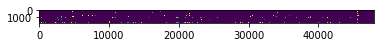

In [0]:
pyplot.imshow(ratings_matrix.toarray())

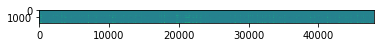

In [0]:
pyplot.imshow(A)

На больших данных заметно, что ошибка высока. В обученной матрице все значения очень близки к нулю. Это связано с тем, что в исходной матрице всего 2% ненулевых значений, то есть вес нуля очень высок и все значения сильно устремились к нему. 

На картинках выше выведены точки в матрицах ratings_matrix (исходные тренировочные данные) и A (обученная матрица).

Именно поэтому обязательно следует исправить исходную матрицу и дозаполнить её.

# Вариант 1.1: присваивание среднего значения оценок, поставленных пользователем, всем неоценённым фильмам

In [0]:
def fill_user_rating_table(A, k):
  U, sigma, Vt = svds(A, k=k)
  sigma = np.diag(sigma)
  return np.dot(np.dot(U, sigma), Vt)

def compute_err_svd(A):
  errors = []
  for i in range(len(test_movies)):
    errors.append(abs(test_ratings[i] - int(round(A[test_movies[i], test_users[i]], 0))))
  return sum(errors)/len(errors)

# errors_row_mean = dict()
# for i in range(10):
#   A = fill_user_rating_table(ratings_matrix_row_mean, (i+1)*20)
#   errors_row_mean[(i+1)*20] = compute_err_svd(A)
A = fill_user_rating_table(ratings_matrix_row_mean, 15)
error_svd_user_mean = compute_err_svd(A)

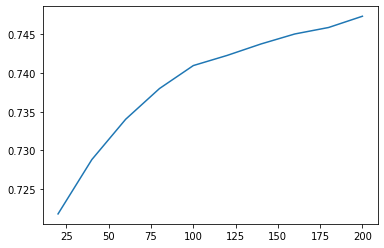

In [0]:
pyplot.plot(list(errors_row_mean.keys()), list(errors_row_mean.values()))

# Вариант 1.2: присваивание среднего значения оценок, поставленных фильму, всем фильмам, которые пользователь не оценил

In [0]:
def fill_user_rating_table(ratings_matrix, k):
  U, sigma, Vt = svds(ratings_matrix.astype('f'), k=k)
  sigma = np.diag(sigma)
  return np.dot(np.dot(U, sigma), Vt)

def compute_err_svd(ratings_matrix):
  errors = []
  for i in range(len(test_movies)):
    errors.append(abs(test_ratings[i] - int(round(ratings_matrix[test_movies[i], test_users[i]], 0))))
  return sum(errors)/len(errors)

errors_col_mean = dict()
for i in range(10):
  A = fill_user_rating_table(ratings_matrix_col_mean, k=(i+1)*20)
  errors_col_mean[(i+1)*20] = compute_err_svd(A)

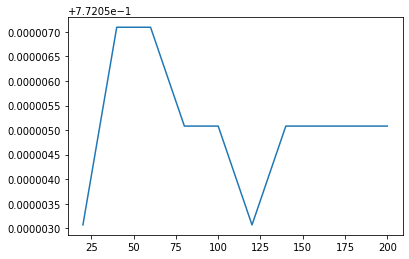

In [0]:
pyplot.plot(list(errors_col_mean.keys()), list(errors_col_mean.values()))

In [0]:
errors_col_mean[20], errors_col_mean[120]

(0.7720530693945703, 0.7720530693945703)

# Вариант 2: KNN item-based

In [0]:
knn_item = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute', n_jobs=-1)
item_based_knn = knn_item.fit(ratings_matrix)

In [0]:
results = item_based_knn.kneighbors(ratings_matrix[[x for x in set(test_movies)], :])

In [88]:
knn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute', n_jobs=-1)

def train_knn(matrix):
  return knn.fit(matrix)

def test_knn_ib(item_based_knn):
  movies_set = set(test_movies)
  movie_indeces = dict()
  current_movie_index = 0
  for movie_id in movies_set:
    movie_indeces[movie_id] = current_movie_index
    current_movie_index+=1
  
  knn_res = item_based_knn.kneighbors(ratings_matrix[[x for x in movies_set], :])

  errors = []
  count_not_predicted_values = 0
  for i in tqdm_notebook(range(len(test_users))):
    count_not_predicted_values += 1
    errors.append(abs(test_ratings[i]))
    for j in knn_res[1][movie_indeces[test_movies[i]]]:
      if ratings_matrix[j, test_users[i]] != 0:
        errors[-1] = abs(test_ratings[i] - ratings_matrix[j, test_users[i]])
        count_not_predicted_values -= 1
        break
  return np.mean(errors), count_not_predicted_values

item_based_knn = train_knn(ratings_matrix)
error_item_based_knn, _ = test_knn_ib(item_based_knn)
error_item_based_knn

0.9482321936892081

В результате нового эксперимента с большим датасетом нашёлся способ работы с большими данными без больших временных затрат. Метод был опробован на большом и более честном, репрезентативном датасете. Ошибка осталась примерно на том же уровне (0.95), хотя и появились значения, для которых нельзя сделать предсказания (19971).

# Вариант 2.1: KNN Item based with weighted nearest neighbours

In [0]:
knn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute', n_jobs=-1)

def train_knn(matrix):
  return knn.fit(matrix)

def predict_for_one(user_id, movie_id, closest_movies_ids, distances_array):
  weights = []
  ratings = []

  for i in range(len(closest_movies_ids)):
    rating = ratings_matrix[closest_movies_ids[i], user_id]
    if rating == 0:
      continue
    ratings.append(rating)
    if distances_array[i] == 0:
      weights.append(np.inf)
    else:
      weights.append(1/distances_array[i])
  if len(weights) == 0:
    return 0
  return int(round(sum(np.array(weights) * np.array(ratings)) / sum(weights), 0))
      


def predict_for_many(item_based_knn, user_ids, movie_ids):
  movie_ids_set = set(movie_ids)
  movie_numbers = {x: i for i, x in enumerate(set(test_movies))}

  distances, closest_neighbours = item_based_knn.kneighbors(
    ratings_matrix[[x for x in movie_ids_set], :]
  )

  predicted_ratings = []
  for i in range(len(user_ids)):
    user_id = user_ids[i]
    movie_id = movie_ids[i]
    closest_movies_ids = closest_neighbours[movie_numbers[movie_ids[i]]]
    distances_array = distances[movie_numbers[movie_ids[i]]]
    predicted_rating = predict_for_one(
      user_id, 
      movie_id, 
      closest_movies_ids, 
      distances_array
    )
    predicted_ratings.append(predicted_rating)
  return predicted_ratings

item_based_knn = train_knn(ratings_matrix)
predicted_ratings_item_based_weighted = predict_for_many(item_based_knn, test_users, test_movies)

In [94]:
error_item_based_weighted = np.mean(np.abs(np.array(predicted_ratings_item_based_weighted) - np.array(test_ratings)))
error_item_based_weighted

0.8171902189766338

# Вариант 3: KNN User based

In [0]:
def train_knn(matrix):
  return knn.fit(matrix)

user_based_knn = train_knn(ratings_matrix.T)

def predict_for_one(user_id, movie_id, closest_users_ids):
  ratings = []

  for i in range(len(closest_users_ids)):
    rating = ratings_matrix[movie_id, closest_users_ids[i]]
    if rating == 0:
      continue
    else:
      return rating
  return 0


def predict_for_many(user_based_knn, user_ids, movie_ids):
  user_ids_set = set(user_ids)
  user_numbers = {x: i for i, x in enumerate(set(test_users))}

  _, closest_neighbours = user_based_knn.kneighbors(
    ratings_matrix[:, [x for x in user_ids_set]].T
  )

  predicted_ratings = []
  for i in range(len(movie_ids)):
    user_id = user_ids[i]
    movie_id = movie_ids[i]
    closest_users_ids = closest_neighbours[user_numbers[user_ids[i]]]
    predicted_rating = predict_for_one(
      user_id, 
      movie_id, 
      closest_users_ids
    )
    predicted_ratings.append(predicted_rating)
  return predicted_ratings

user_based_knn = train_knn(ratings_matrix.T)
predicted_ratings_user_based = predict_for_many(user_based_knn, test_users, test_movies)

In [87]:
error_ratings_user_based = np.mean(np.abs(np.array(predicted_ratings_user_based) - np.array(test_ratings)))
error_ratings_user_based

1.3374875524306709

# Вариант 3.1: KNN User based with weights



In [0]:
def train_knn(matrix):
  return knn.fit(matrix)

user_based_knn = train_knn(ratings_matrix.T)

def predict_for_one(user_id, movie_id, closest_users_ids, distances_array):
  weights = []
  ratings = []

  for i in range(len(closest_users_ids)):
    rating = ratings_matrix[movie_id, closest_users_ids[i]]
    if rating == 0:
      continue
    ratings.append(rating)
    if distances_array[i] == 0:
      weights.append(np.inf)
    else:
      weights.append(1/distances_array[i])
  if len(weights) == 0:
    return 0
  return int(round(sum(np.array(weights) * np.array(ratings)) / sum(weights), 0))      


def predict_for_many(user_based_knn, user_ids, movie_ids):
  user_ids_set = set(user_ids)
  user_numbers = {x: i for i, x in enumerate(set(test_users))}

  distances, closest_neighbours = user_based_knn.kneighbors(
    ratings_matrix[:, [x for x in user_ids_set]].T
  )

  predicted_ratings = []
  for i in range(len(movie_ids)):
    user_id = user_ids[i]
    movie_id = movie_ids[i]
    closest_users_ids = closest_neighbours[user_numbers[user_ids[i]]]
    distances_array = distances[user_numbers[user_ids[i]]]
    predicted_rating = predict_for_one(
      user_id, 
      movie_id, 
      closest_users_ids, 
      distances_array
    )
    predicted_ratings.append(predicted_rating)
  return predicted_ratings

user_based_knn = train_knn(ratings_matrix.T)
predicted_ratings_user_based_weighted = predict_for_many(user_based_knn, test_users, test_movies)

In [80]:
error_user_based_weighted = np.mean(np.abs(np.array(predicted_ratings_user_based_weighted) - np.array(test_ratings)))
error_user_based_weighted

1.1928281883380105

# Вариант 4: Item based & User based

Если просто взять взвешенную сумму

In [86]:
item_based_weighted_weight = 1/error_item_based_weighted
user_based_weighted_weight = 1/error_user_based_weighted
mixed_user_item_based_predicted_ratings = [int(
    round((
        item_based_weighted_weight*predicted_ratings_item_based_weighted[i] + 
        user_based_weighted_weight*predicted_ratings_user_based_weighted[i]) / 
        (item_based_weighted_weight+user_based_weighted_weight), 0)) 
for i in range(len(predicted_ratings_item_based_weighted))
]
np.mean(np.abs(np.array(mixed_user_item_based_predicted_ratings) - np.array(test_ratings)))

0.8787028375428749

# Вариант 5: лучший результат

In [95]:
svd_user_mean_rating_prediction = []
for i in range(len(test_users)):
  svd_user_mean_rating_prediction.append(A[test_movies[i], test_users[i]])

knn_p = np.array(predicted_ratings_item_based_weighted)
svd_p = np.array(svd_user_mean_rating_prediction)

svd_w = 1/error_svd_user_mean
knn_w = 1/error_item_based_weighted

np.mean(np.abs((svd_w * svd_p + knn_w * knn_p)/(svd_w+knn_w) - np.array(test_ratings)))

0.75952810027115